Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [50]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = 'data/'

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [52]:
import category_encoders as ce
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
import pandas_profiling

In [45]:
# profile = train.profile_report()

In [46]:
profile

In [53]:
rejected_variables = profile.get_rejected_variables(threshold=0.9)
rejected_variables

['gps_height_MISSING',
 'longitude_MISSING',
 'population_MISSING',
 'years_MISSING']

In [54]:
train, val = train_test_split(train, test_size=len(test), stratify=train['status_group'], random_state=42)

def wrangle(X):
    X = X.copy()
    
    #Clean up latitude
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Make columns for missing values
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'gps_height', 'population']
    
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
    
    # Remove duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Remove columns with meaningless variance
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Make date_recorded datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Split date_recorded into year, month, day columns
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Calculate feature for years between observation and construction
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # Remove features with > 90% correlation with other features
    X = X.drop(columns=rejected_variables)
    
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [55]:
target = 'status_group'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [56]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8127176486975902


In [57]:
val.shape

(14358, 42)

# Confusion Matrix

In [58]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[6992,  172,  634],
       [ 544,  341,  158],
       [1105,   76, 4336]], dtype=int64)

In [59]:
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

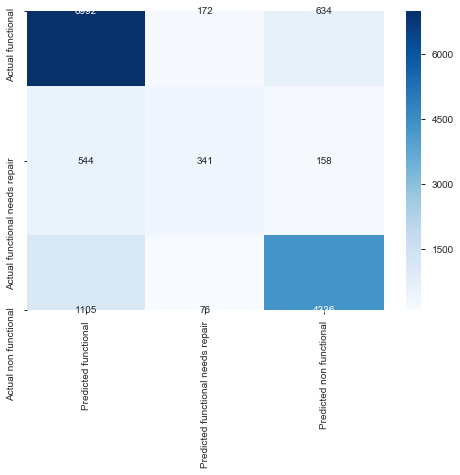

In [60]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                     columns = columns,
                     index = index)
    return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred)

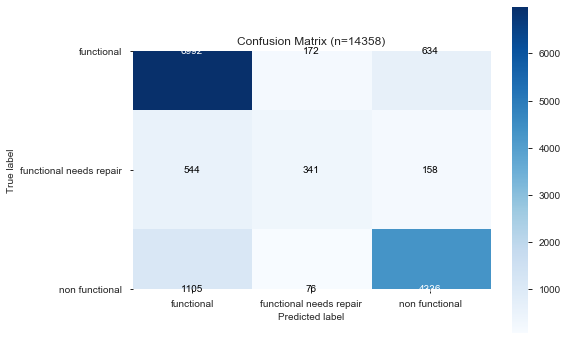

In [61]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred,
                                   figsize=(8,6),
                                   title=f'Confusion Matrix (n={len(y_val)})',
                                   normalize=False);

In [64]:
# Calculate accuracy by hand

correct_preds = 6992 + 341 + 4336
total_preds = len(y_val)
accuracy = correct_preds / total_preds

print('Accuracy', accuracy)

Accuracy 0.8127176486975902


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.33      0.42      1043
         non functional       0.85      0.79      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.74      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



In [66]:
confusion_matrix(y_val, y_pred)

array([[6992,  172,  634],
       [ 544,  341,  158],
       [1105,   76, 4336]], dtype=int64)

In [67]:
# Calculate precision by hand for class 'non functional'

true_positives = 4336
total_preds = 634 + 158 + 4336
precision = true_positives / total_preds
print('Precision', precision)

Precision 0.8455538221528861


In [68]:
# Calculate recall by hand for class 'non functional'

total_true = 1105 + 76 + 4336
recall = true_positives / total_true
print('Recall', recall)

Recall 0.7859343846293275
